In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare the sample data

In [2]:
N_half = 1000
bandwidth = 0.03
horizontal_data = np.array([
                        np.arange(-1.0, 1.0, 2/N_half) + np.random.uniform(-bandwidth, bandwidth, N_half),
                        np.zeros(N_half) + np.random.uniform(-bandwidth, bandwidth, N_half)
                        ]).T
vertical_data = np.array([
                        np.zeros(N_half) + np.random.uniform(-bandwidth, bandwidth, N_half),
                        np.arange(-1.0, 1.0, 2/N_half) + np.random.uniform(-bandwidth, bandwidth, N_half)
                        ]).T

sample_data = np.concatenate([horizontal_data, vertical_data], axis=0)
n = 2 * N_half
rnd_idx = np.random.choice(n, n,replace=False)
sample_data = sample_data[rnd_idx, :]

### Plot the sample data

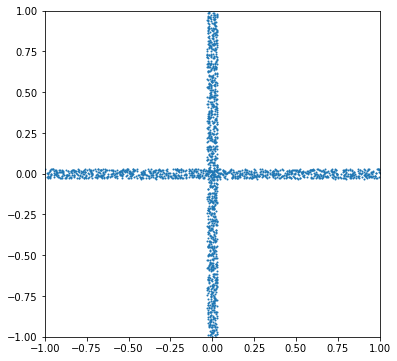

In [3]:
matplotlib.pyplot.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(sample_data[:,0], sample_data[:,1], "o", markersize=1) 
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

### Algorithm 4
#### Step 0, create y_1, ... y_n0
#### Step 1, create C_i, ... C_n0, and Q_i, ... Q_n0

In [7]:
r = 0.05
ramaining_index_list = list(range(n))
full_index_list = list(range(n))

N_y_list = []
np.random.seed(0)
d = 1                          # intrinsic dimension

while ramaining_index_list:
    y_seed_num = np.random.choice(ramaining_index_list)        # Pick up y_i's index randomly
    ramaining_index_list.remove(y_seed_num)                    # Remove y_i's index form the residual list
    y_i = sample_data[y_seed_num]                              # Get y_i

    N_y_i_list = list([i for i in full_index_list if np.linalg.norm(sample_data[i] - y_i) < r]) # Get N(y_i)'s index
    N_y_i = sample_data[N_y_i_list]                            # Get N(y_i)
    N_y_i = np.concatenate([N_y_i, y_i.reshape(1, 2)], axis=0) # Merge y_i and N(y_i)

    number_set = set(ramaining_index_list) - set(N_y_i_list)
    ramaining_index_list = list(number_set)                    # Remove N(y_i)'s index form the residual list

    N_y_i_list.append(y_seed_num)                              # Merge y_i's index and N(y_i)'s index

    C = np.cov(N_y_i, rowvar=0, bias=0)                        # Covariance Matrix for N(y_i)
    
    eigen_value, eigen_vector = np.linalg.eig(C)
    top_index = eigen_value.argsort()[::-1][0:d]
    P = eigen_vector[:, top_index]                             # P is a matrix whose columns are the top d eigenvectors of C
    Q = np.dot(P, P.T)                                         # Get the orthogonal projection matrix

# This is wrong!
#    Q = np.dot(np.dot(P, P.T), y_i)    # Get the orthogonal projection of y_i 
#                                       # onto the space spanned by the top d egenvectors of C

    # OUTPUT
    N_y_list.append([y_i,
                     N_y_i_list,
                     N_y_i,
                     C,
                     Q])

### Define the fuction of Spectral Graph Partitioning (Algorithm 1)

In [8]:
def SpectralGraphPartitioning(W, K):
    W_rowsum = W.sum(axis=1)
    Z = W / np.sqrt(np.outer(W_rowsum, W_rowsum)) # Step 1, Compute Z
    eigen_value, eigen_vector = np.linalg.eig(Z)
    top_index = eigen_value.argsort()[::-1][0:K]
    out_matrix = eigen_vector[:, top_index]       # Step 2, Extract the top K eigenvectors of Z
    out_matrix = out_matrix / np.c_[np.linalg.norm(out_matrix, axis=1)] # Step 3, Renormalize each row of the resulting n * K matrix

    kmeans = KMeans(n_clusters=2, random_state=0).fit(out_matrix) # Step 4, Apply K-means to the row vector
    return kmeans.labels_

#### Step 2, Compute the affinities W_ij
#### Step 3, Apply Spectral Graph Partitioning (algorithm 1) to W_ij

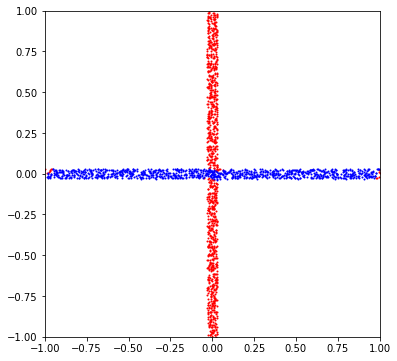

In [9]:
# Algorithm 4, Step 2, Compute the following affinities W_ij
eps = 1.0
eta = 1.0

n0 = len(N_y_list)
W = np.zeros([n0, n0])
for i in range(n0):
    for j in range(n0):
        W[i][j] = np.exp(-np.linalg.norm(N_y_list[i][0] - N_y_list[j][0])**2 / eps**2) \
                * np.exp(-np.linalg.norm(N_y_list[i][4] - N_y_list[j][4])**2 / eta**2)
        
# Algorithm 4, Step 3
# Use algorithm 1, Spectral Graph Partitioning
y_class = SpectralGraphPartitioning(W=W, K=2)


# Create y array for the next calculation to find the closest y_j 
y = np.empty((0,2), float)
for i in range(n0):
    y = np.append(y, np.r_[N_y_list[i][0]].reshape(1,2), axis=0)

# Algorithm 4, Step 4
# For all sample data x_i, find the closest y_j 
result_data = np.empty((0,3), float)
for i in range(n):
    min_index = np.argmin(np.linalg.norm(y - np.r_[sample_data[i]], axis=1))
    result_data = np.append(result_data, [[sample_data[i][0], sample_data[i][1], y_class[min_index]]], axis=0)
        

# Plot the final result
matplotlib.pyplot.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(result_data[:,0][result_data[:,2]==0], result_data[:,1][result_data[:,2]==0], "o", markersize=1, c='red') 
plt.plot(result_data[:,0][result_data[:,2]==1], result_data[:,1][result_data[:,2]==1], "o", markersize=1, c='blue') 
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()